## Import Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

#### Import dataset

In [59]:
# Load the dataset
path='./BackEnd/Credit_score/data/data_microfinance.csv'
df = pd.read_csv(path, parse_dates=['TransactionStartTime'])

# Display basic info
print(f"Dataset contains {len(df)} transactions")
print(f"Date range: {df['TransactionStartTime'].min()} to {df['TransactionStartTime'].max()}")
print("\nSample data:")
display(df.head())

Dataset contains 95662 transactions
Date range: 2018-11-15 02:18:49+00:00 to 2019-02-13 10:01:28+00:00

Sample data:


,TransactionId,AccountId,CustomerId,Amount,Value,TransactionStartTime
0,TransactionId_76871,AccountId_3957,CustomerId_4406,1000.0,1000,2018-11-15 02:18:49+00:00
1,TransactionId_73770,AccountId_4841,CustomerId_4406,-20.0,20,2018-11-15 02:19:08+00:00
2,TransactionId_26203,AccountId_4229,CustomerId_4683,500.0,500,2018-11-15 02:44:21+00:00
3,TransactionId_380,AccountId_648,CustomerId_988,20000.0,21800,2018-11-15 03:32:55+00:00
4,TransactionId_28195,AccountId_4841,CustomerId_988,-644.0,644,2018-11-15 03:34:21+00:00


### Data Cleaning & Preprocessing

In [60]:
# 1. Check for missing values
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# 2. Impute or drop missing values if any
# Fill NaN values with mean of the distribution
if missing_counts.any():
    df = df.fillna(df.mean(numeric_only=True))
    print("\nFilled missing numeric values with column means.")

# 3. Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nDuplicate rows in X: {duplicate_count}")

# Remove duplicates if any
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Removed duplicate rows.")

# 4. Outlier detection (optional, here using z-score for numeric columns)

z_scores = df.select_dtypes(include=[np.number]).apply(zscore)
outlier_mask = (np.abs(z_scores) > 5).any(axis=1)
outlier_count = outlier_mask.sum()
print(f"\nRows with extreme outliers (z-score > 5): {outlier_count}")

# Optionally remove outliers
if outlier_count > 0:
    df = df[~outlier_mask]
    print("Removed rows with extreme outliers.")

# 5. Feature scaling (standardization) //Will be done during modelling

Missing values per column:
 TransactionId           0
AccountId               0
CustomerId              0
Amount                  0
Value                   0
TransactionStartTime    0
dtype: int64

Duplicate rows in X: 0

Rows with extreme outliers (z-score > 5): 156
Removed rows with extreme outliers.


### Feature Engineering

In [61]:
def extract_features_from_transactions(group):
    """Extract credit score features from a customer's transaction history with realistic loan synthesis."""
    if group.empty:
        return None

    # Sort by transaction time
    group = group.sort_values('TransactionStartTime')
    first_trans = group['TransactionStartTime'].min()
    last_trans = group['TransactionStartTime'].max()

    # Basic transaction masks
    deposit_mask = group['Amount'] > 0
    withdrawal_mask = group['Amount'] < 0

    # Totals
    total_deposits = group.loc[deposit_mask, 'Amount'].sum()
    total_withdrawals = group.loc[withdrawal_mask, 'Amount'].abs().sum()

    # Timezone-aware, get it to start from 2020 since the dataset we are using is a while ago
    now = pd.Timestamp('2020-01-01', tz=last_trans.tz) if last_trans.tzinfo else pd.Timestamp('2020-01-01')

    # Base features
    features = {
        'customer_id': group['CustomerId'].iloc[0],
        'transaction_count': len(group),
        'deposit_count': deposit_mask.sum(),
        'withdrawal_count': withdrawal_mask.sum(),
        'avg_transaction_amount': group['Amount'].abs().mean(),
        'total_deposits': total_deposits,
        'total_withdrawals': total_withdrawals,
        'days_since_last_transaction': (now - last_trans).days,
        'account_utilization': min(total_withdrawals / max(total_deposits, 1), 1.5),
        'account_age_days': max((last_trans - first_trans).days, 1),
        'total_balance': group['Amount'].sum(),
    }

    # Balance volatility
    try:
        daily_balances = group.set_index('TransactionStartTime').resample('D')['Amount'].sum().cumsum()
        features['balance_volatility'] = daily_balances.std()
    except Exception:
        features['balance_volatility'] = 0

    # Payment consistency
    time_diffs = group['TransactionStartTime'].sort_values().diff().dt.days.dropna()
    if time_diffs.empty or time_diffs.mean() == 0 or len(time_diffs) < 3:
        features['payment_consistency'] = 0.5
    else:
        features['payment_consistency'] = 1 - (time_diffs.std() / time_diffs.mean())

    # Overdraft usage
    running_balance = group['Amount'].cumsum()
    features['overdraft_usage'] = (running_balance < 0).mean()

    # Realistic Loan Feature Synthesis
    import re
    customer_id_str = str(group['CustomerId'].iloc[0])
    match = re.search(r'\d+', customer_id_str)
    customer_id_int = int(match.group()) if match else 0
    np.random.seed(customer_id_int % (2**32 - 1))

    # Behavior-derived heuristics
    income_capacity = total_deposits / features['account_age_days']
    loan_need_likelihood = min(1.0, 1 - features['payment_consistency'] + features['account_utilization'])

    # Loan count
    loan_count = np.random.poisson(lam=loan_need_likelihood * 2)
    loan_count = int(np.clip(loan_count, 0, 5))

    # Loan amount scales with income
    loan_scale = np.clip(total_deposits, 5000, 200000)
    total_loan_amount = int(np.random.uniform(0.1, 0.6) * loan_scale) if loan_count > 0 else 0
    avg_loan_amount = total_loan_amount / loan_count if loan_count > 0 else 0

    # Improved repayment modeling
    if loan_count > 0:
        base_repaid_prob = np.clip(features['payment_consistency'], 0.3, 0.95)

        # Add small probability for full/default behavior
        if np.random.rand() < 0.05:
            repaid_loans = loan_count
        elif np.random.rand() < 0.05:
            repaid_loans = 0
        else:
            repaid_loans = np.random.binomial(n=loan_count, p=base_repaid_prob)
    else:
        repaid_loans = 0

    outstanding_loans = loan_count - repaid_loans
    repayment_ratio = repaid_loans / loan_count if loan_count > 0 else 1.0
    loan_to_deposit_ratio = total_loan_amount / max(total_deposits, 1)

    # Append loan features
    features.update({
        'loan_count': loan_count,
        'total_loan_amount': total_loan_amount,
        'avg_loan_amount': avg_loan_amount,
        'repaid_loans': repaid_loans,
        'outstanding_loans': outstanding_loans,
        'repayment_ratio': repayment_ratio,
        'loan_to_deposit_ratio': loan_to_deposit_ratio
    })

    return features

customer_groups = df.groupby('CustomerId')
features_list = []

for customer_id, group in customer_groups:
    features = extract_features_from_transactions(group)
    if features:
        features_list.append(features)

feature_df = pd.DataFrame(features_list)
feature_df.fillna({
    'balance_volatility': 0,
    'payment_consistency': 0.5,
    'overdraft_usage': 0
}, inplace=True)


### Calculate Synthetic credit score based on the users history

In [62]:
def calculate_synthetic_credit_scores(feature_df):
    """
    Generate balanced synthetic credit scores using reweighted features
    and normalize to a uniform 300–850 distribution via quantile binning.
    """
    raw_scores = []
    
    for _, row in feature_df.iterrows():
        score = 0

        # Account age factor (down-weighted)
        score += min(np.log1p(row['account_age_days']) * 15, 70)

        # Balance factor (log-transformed, capped)
        score += min(np.log1p(max(row['total_balance'], 0)) * 6, 60)

        # Transaction activity (down-weighted)
        score += min(row['transaction_count'] * 1.0, 60)

        # Payment consistency (reduced influence)
        score += row['payment_consistency'] * 50

        # Account utilization (still rewarded for lower utilization)
        util = min(row['account_utilization'], 0.9)
        score += (1 - util) * 25

        # Overdraft penalty (kept same)
        score -= row['overdraft_usage'] * 40

        # Balance volatility penalty (slightly increased penalty)
        score -= min(row['balance_volatility'] * 0.15, 40)

        if 1 <= row['loan_count'] <= 3 and row['repayment_ratio'] > 0.75:
            score += 10


        # Recent activity bonus
        last_active = row['days_since_last_transaction']
        if last_active <= 7:
            score += 15
        elif last_active <= 30:
            score += 5

        raw_scores.append(score)

    # Quantile-based normalization to 300–850
    raw_scores = np.array(raw_scores)
    quantiles = pd.qcut(raw_scores, q=100, labels=False, duplicates='drop')
    norm_scores = 300 + (quantiles / quantiles.max()) * (850 - 300)
    
    return norm_scores

feature_df['credit_score'] = calculate_synthetic_credit_scores(feature_df)
print("\nCredit score distribution:")
print(feature_df['credit_score'].describe())



Credit score distribution:
count    3727.000000
mean      583.648989
std       158.651575
min       300.000000
25%       446.467391
50%       592.934783
75%       727.445652
max       850.000000
Name: credit_score, dtype: float64


,transaction_count,deposit_count,withdrawal_count,avg_transaction_amount,total_deposits,total_withdrawals,days_since_last_transaction,account_utilization,account_age_days,total_balance,...,payment_consistency,overdraft_usage,loan_count,total_loan_amount,avg_loan_amount,repaid_loans,outstanding_loans,repayment_ratio,loan_to_deposit_ratio,credit_score
transaction_count,1.00,0.72,0.92,-0.03,0.24,0.69,-0.15,-0.01,0.30,-0.58,...,-0.66,0.01,0.04,0.24,0.20,-0.00,0.05,-0.04,-0.03,-0.19
deposit_count,0.72,1.00,0.39,-0.04,0.37,-0.00,-0.23,-0.10,0.42,0.12,...,-0.66,-0.08,0.08,0.38,0.32,0.01,0.09,-0.07,-0.06,-0.24
withdrawal_count,0.92,0.39,1.00,-0.01,0.11,0.91,-0.08,0.04,0.16,-0.83,...,-0.50,0.06,0.01,0.11,0.09,-0.01,0.02,-0.01,-0.01,-0.12
avg_transaction_amount,-0.03,-0.04,-0.01,1.00,0.23,0.01,0.04,0.03,-0.08,0.06,...,0.08,0.11,-0.05,0.14,0.16,-0.00,-0.06,0.07,0.11,0.11
total_deposits,0.24,0.37,0.11,0.23,1.00,0.00,-0.10,-0.07,0.17,0.31,...,-0.24,-0.05,0.02,0.29,0.26,0.03,0.01,-0.01,-0.03,-0.09
total_withdrawals,0.69,-0.00,0.91,0.01,0.00,1.00,-0.01,0.07,0.03,-0.95,...,-0.26,0.09,-0.02,-0.01,-0.00,-0.01,-0.01,0.02,0.00,-0.03
days_since_last_transaction,-0.15,-0.23,-0.08,0.04,-0.10,-0.01,1.00,0.02,-0.49,-0.03,...,0.29,0.08,-0.11,-0.26,-0.22,0.01,-0.14,0.11,0.06,0.18
account_utilization,-0.01,-0.10,0.04,0.03,-0.07,0.07,0.02,1.00,-0.05,-0.09,...,0.10,0.85,0.10,-0.12,-0.11,0.10,0.04,-0.02,0.60,-0.28
account_age_days,0.30,0.42,0.16,-0.08,0.17,0.03,-0.49,-0.05,1.00,0.02,...,-0.47,-0.04,0.17,0.48,0.39,0.02,0.19,-0.14,-0.01,-0.29
total_balance,-0.58,0.12,-0.83,0.06,0.31,-0.95,-0.03,-0.09,0.02,1.00,...,0.17,-0.10,0.03,0.10,0.09,0.02,0.02,-0.02,-0.01,0.00


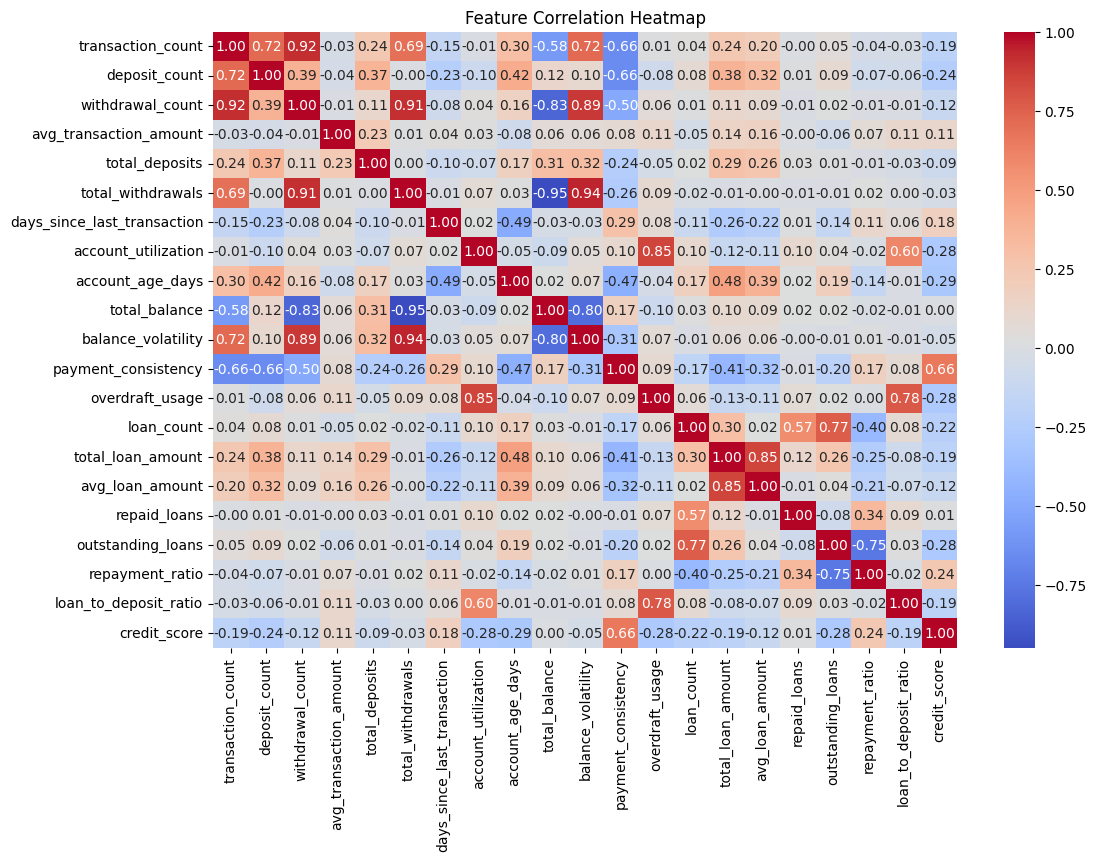

In [63]:
plt.figure(figsize=(12, 8))
feat_df_corr = feature_df.drop(columns='customer_id')
corr_matrix = feat_df_corr.corr().round(2)
display(corr_matrix)  # Show the correlation matrix as a table

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

### Visualize Feature Distributions and Relationships

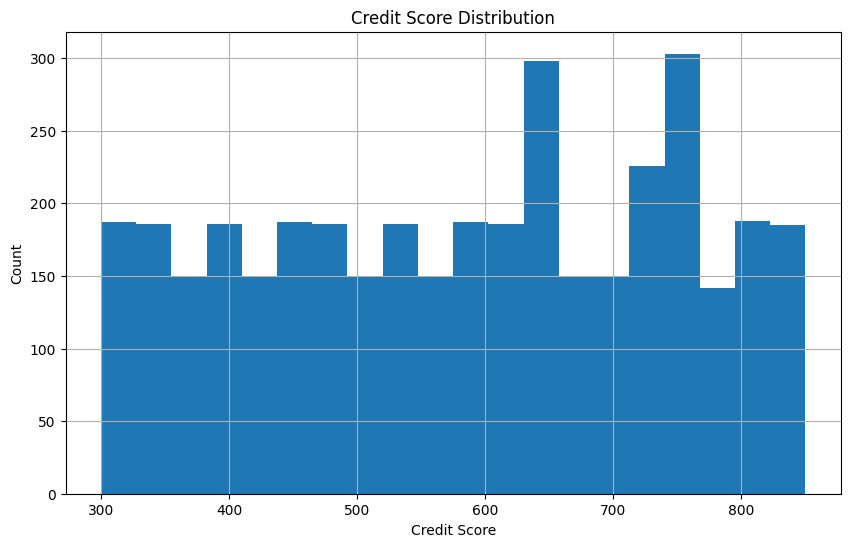

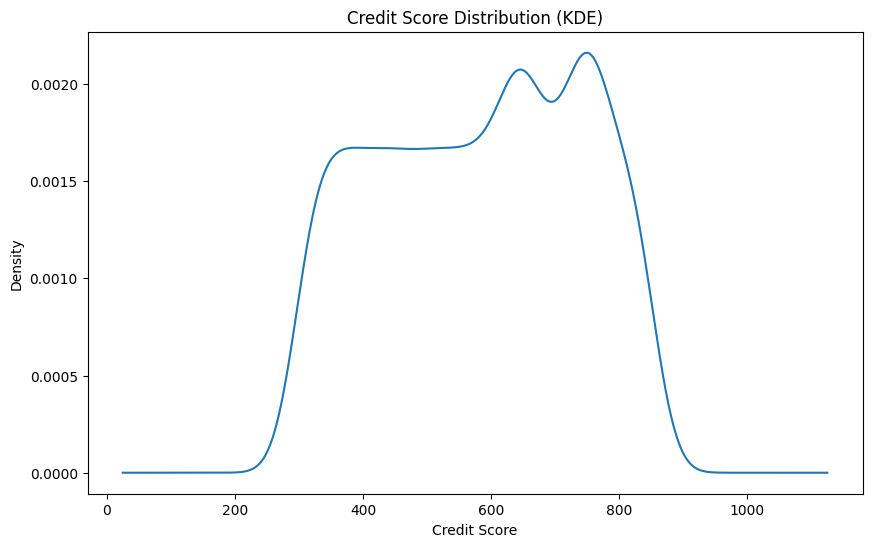


Saved engineered features to engineered_credit_features.csv

Data ready for model training!
X shape: (3727, 20), y shape: (3727,)


In [64]:
feature_df['credit_score'].hist(bins=20, figsize=(10, 6))
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.show()

feature_df['credit_score'].plot(kind='kde', figsize=(10, 6))
plt.title('Credit Score Distribution (KDE)')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.show()


# Save engineered dataset
feature_df.to_csv('./BackEnd/Credit_score/data/engineered_credit_features.csv', index=False)
print("\nSaved engineered features to engineered_credit_features.csv")


# Prepare for model training
df = feature_df.drop(columns=['customer_id', 'credit_score'])
y = feature_df['credit_score']

print("\nData ready for model training!")
print(f"X shape: {df.shape}, y shape: {y.shape}")

In [65]:
display(feature_df)

,customer_id,transaction_count,deposit_count,withdrawal_count,avg_transaction_amount,total_deposits,total_withdrawals,days_since_last_transaction,account_utilization,account_age_days,...,payment_consistency,overdraft_usage,loan_count,total_loan_amount,avg_loan_amount,repaid_loans,outstanding_loans,repayment_ratio,loan_to_deposit_ratio,credit_score
0,CustomerId_1,1,0,1,10000.000000,0.0,10000.0,405,1.500000,1,...,0.500000,1.0,2,1255,627.5,0,2,0.000000,1255.000000,383.695652
1,CustomerId_10,1,0,1,10000.000000,0.0,10000.0,405,1.500000,1,...,0.500000,1.0,1,2084,2084.0,0,1,0.000000,2084.000000,383.695652
2,CustomerId_1001,5,3,2,6080.000000,25200.0,5200.0,410,0.206349,1,...,0.500000,0.0,1,4990,4990.0,0,1,0.000000,0.198016,766.304348
3,CustomerId_1002,11,5,6,434.090909,4500.0,275.0,347,0.061111,63,...,-0.917169,0.0,0,0,0.0,0,0,1.000000,0.000000,545.108696
4,CustomerId_1003,6,4,2,5333.333333,26000.0,6000.0,333,0.230769,1,...,0.500000,0.0,2,10356,5178.0,0,2,0.000000,0.398308,766.304348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,CustomerId_992,6,4,2,5333.333333,26000.0,6000.0,326,0.230769,1,...,0.500000,0.0,0,0,0.0,0,0,1.000000,0.000000,766.304348
3723,CustomerId_993,5,3,2,6400.000000,26000.0,6000.0,347,0.230769,1,...,0.500000,0.0,1,8607,8607.0,0,1,0.000000,0.331038,760.326087
3724,CustomerId_994,101,61,40,6060.663366,578000.0,34127.0,322,0.059043,88,...,-1.410319,0.0,2,105786,52893.0,1,1,0.500000,0.183021,646.739130
3725,CustomerId_996,17,15,2,8882.352941,145000.0,6000.0,389,0.041379,1,...,0.500000,0.0,0,0,0.0,0,0,1.000000,0.000000,850.000000
